In [17]:
import requests
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sb
sb.set()
import json
import time
from pandas.plotting import scatter_matrix
from datetime import datetime


%matplotlib inline


api_key = 'OjNmN2Y1ODNlMGUzODhkYjg5ZmNlYmUwZWRmNTcwZjM5'

questa funzione chiama direttamente intrinio

In [18]:
#parametri 
start_year = 2014
end_year = 2020
ticker_id = 'AAPL'
ris=[]

In [6]:
def get_foundamental_data_raw(ticker_id, statement_code, year, quarter=None):
    # recupero data_id
    fundamental_lookup_uri = 'https://api-v2.intrinio.com/fundamentals/lookup/{0}/{1}/{2}/{3}?api_key={4}'.format(
        ticker_id, statement_code, year, quarter, api_key)
    response = requests.get(fundamental_lookup_uri)
    data = response.json()
    if 'id' in data:
        id = data['id']
        # ritorno il json di risposta
        fundamentals_data_uri = 'https://api-v2.intrinio.com/fundamentals/{0}/standardized_financials?api_key={1}'.format(
            id, api_key)
        response = requests.get(fundamentals_data_uri)
        data = response.json()
        time.sleep(5)
        return data
    
    return None

questa funzione chiama per estrapola tutti i quarter e li formatta
modificare la struttura di salvataggio per farla digerire a pandas

In [84]:
def format_data(ticker_id, start_year, end_year):
    
    print("Downloading...\n")
    years = np.arange(start_year, end_year)
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    
    calculations = None
    calculations_copy = None
    index = None
    
    is_fist_element = True
    
    data_list = list()
    current_ratio_list = list()
    profit_margin_list = list()
    asset_turnover_list = list()
    roe_list = list()
    roa_list = list()
    pricetoearnings_list = list()
    adjdilutedeps_list = list()
    debttoequity_list = list()
    freecashflow_list = list()
    invturnover_list = list()
    
    
    for year in years:
        for quarter in quarters:
            
            calculations = get_foundamental_data_raw(ticker_id, 'calculations', year, quarter)
           
            if(calculations != None):
                is_fist_element = False
                #copio i valori per quando si verifichera la calculation == None
                calculations_copy = calculations
                index = calculations['fundamental']['end_date']
                current_ratio = None
                #aggiorno le liste
                for element in calculations['standardized_financials']:
                    if(element['data_tag']['tag'] == 'currentratio'):
                        current_ratio_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'profitmargin'):
                        profit_margin_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'assetturnover'):
                        asset_turnover_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'roe'):
                        roe_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'roa'):
                        roa_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'pricetoearnings'):
                        pricetoearnings_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'adjdilutedeps'):
                        adjdilutedeps_list.append(element['value'])
                    if(element['data_tag']['tag'] == 'debttoequity'):
                        debttoequity_list.append(element['value'])   
                    if(element['data_tag']['tag'] == 'freecashflow'):
                        freecashflow_list.append(element['value'])  
                    if(element['data_tag']['tag'] == 'invturnover'):
                        invturnover_list.append(element['value']) 
                    
                print(str(year) + "-" + str(quarter))        
                #collection dove salvo i dati
                data_list.append(str(index))
                
            else:
                if (is_fist_element == True):
                    continue
                if (is_fist_element == False):
                    #quando arrivo all'ultimo trimestre copio i dati fino alla data attuale
                    print("break "+str(year) + "-" + str(quarter)) 
                    index = datetime.today().strftime('%Y-%m-%d')
                    data_list.append(str(index))
                    for element in calculations_copy['standardized_financials']:
                        if(element['data_tag']['tag'] == 'currentratio'):
                            current_ratio_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'profitmargin'):
                            profit_margin_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'assetturnover'):
                            asset_turnover_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'roe'):
                            roe_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'roa'):
                            roa_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'pricetoearnings'):
                            pricetoearnings_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'adjdilutedeps'):
                            adjdilutedeps_list.append(element['value'])
                        if(element['data_tag']['tag'] == 'debttoequity'):
                            debttoequity_list.append(element['value']) 
                        if(element['data_tag']['tag'] == 'freecashflow'):
                            freecashflow_list.append(element['value'])  
                        if(element['data_tag']['tag'] == 'invturnover'):
                            invturnover_list.append(element['value'])             
                    break;
                
    
    # preparo la struttura per pandas            
    result = {str(ticker_id): 
              {'date': data_list, 
               'currentratio': current_ratio_list, 
               'profitmargin': profit_margin_list,
               'assetturnover': asset_turnover_list,
               'roe': roe_list,
               'roa': roa_list,
               'pricetoearnings': pricetoearnings_list,
               'eps': adjdilutedeps_list,
               'debttoequity': debttoequity_list,
               'freecashflow': freecashflow_list,
               'invturnover':invturnover_list
               }}          
    print("\nDownload completed!")
    return result
            

In [85]:
def get_all_tickers_from_api():
    all_tickers_uri = 'https://api-v2.intrinio.com/companies?api_key={0}'.format(api_key)
    response = requests.get(all_tickers_uri)
    data = response.json()

    ticker_dictionary = {}
    for i in data['companies']:
        ticker_dictionary[i['ticker']] = i['name']
    return ticker_dictionary

In [86]:

ticker_id = 'AAPL'

ris = format_data(ticker_id, start_year, end_year)

Downloading...

2014-Q1
2014-Q2
2014-Q3
2014-Q4
2015-Q1
2015-Q2
2015-Q3
2015-Q4
2016-Q1
2016-Q2
2016-Q3
2016-Q4
2017-Q1
2017-Q2
2017-Q3
2017-Q4
2018-Q1
2018-Q2
2018-Q3
2018-Q4
2019-Q1
2019-Q2
break 2019-Q3

Download completed!


Manipolazione dataframe pandas

In [87]:
def fundamentals_pandas_manipulation(data):
    for element in data:
        df = pd.DataFrame.from_dict(data[str(element)])
        df.set_index('date', inplace=True)
        df.index =  pd.to_datetime(df.index)
        #ricampiono la base dati
        upsampled = df.resample('D').asfreq()
        return upsampled.ffill()
print(ris)
fundamental_ratio_table = fundamentals_pandas_manipulation(ris)
print(fundamental_ratio_table)

{'AAPL': {'date': ['2013-12-28', '2014-03-29', '2014-06-28', '2014-09-27', '2014-12-27', '2015-03-28', '2015-06-27', '2015-09-26', '2015-12-26', '2016-03-26', '2016-06-25', '2016-09-24', '2016-12-31', '2017-04-01', '2017-07-01', '2017-09-30', '2017-12-30', '2018-03-31', '2018-06-30', '2018-09-29', '2018-12-29', '2019-03-30', '2019-06-08'], 'currentratio': [1.4943, 1.6326, 1.4706, 1.0801, 1.133, 1.156, 1.0868, 1.1088, 1.0017, 1.2831, 1.3116, 1.3527, 1.2282, 1.3906, 1.3883, 1.2761, 1.242, 1.456, 1.3073, 1.1329, 1.3006, 1.3154, 1.3154], 'profitmargin': [0.226968, 0.223963, 0.206989, 0.201007, 0.241612, 0.233908, 0.21524, 0.215996, 0.242, 0.208003, 0.18405, 0.192393, 0.228344, 0.208503, 0.191971, 0.20377, 0.227255, 0.226082, 0.216258, 0.224563, 0.236805, 0.199276, 0.199276], 'assetturnover': [0.826, 0.8786, 0.8435, 0.8331, 0.8204, 0.9083, 0.9052, 0.8951, 0.8465, 0.8033, 0.7613, 0.7047, 0.6986, 0.6891, 0.6869, 0.6578, 0.6482, 0.7049, 0.7353, 0.7168, 0.6704, 0.7287, 0.7287], 'roe': [0.288145

download prezzo delle azioni

In [19]:
# qui va strutturato un metodo
start = datetime(start_year, 1, 1)
end = datetime.today().strftime('%Y-%m-%d')

start_price = datetime(2006, 1, 1)
end_price = datetime.today().strftime('%Y-%m-%d')

yf.pdr_override() # <== that's all it takes :-)

#scarico altri dati per i prezzi
stocks_price = 'AAPL ^GSPC ^VIX'
stocks_price = stocks_price.split()

stocks = '^GSPC ^VIX'
stocks = stocks.split()

for el in ris:
    stocks.append(str(el))
                  
# download dataframe
stocks = pdr.get_data_yahoo(stocks, start=start, end=end)
stocks_close = stocks['Adj Close']
print(stocks['Adj Close'].head())

stocks_price = pdr.get_data_yahoo(stocks_price, start=start_price, end=end_price)
stocks_price_close = stocks_price['Adj Close']
stocks_price_close.rename(columns={ticker_id:'stock_price'}, inplace=True)
print(stocks_price_close.head())
stocks_price_close.to_csv('{0}_price.csv'.format(ticker_id))

[*********************100%***********************]  2 of 2 downloaded
              ^GSPC   ^VIX
Date                      
2013-12-31  1848.36  13.72
2014-01-02  1831.98  14.23
2014-01-03  1831.37  13.76
2014-01-06  1826.77  13.55
2014-01-07  1837.88  12.92
[*********************100%***********************]  3 of 3 downloaded
            stock_price    ^GSPC   ^VIX
Date                                   
2006-01-03         9.35  1268.80  11.14
2006-01-04         9.38  1273.46  11.37
2006-01-05         9.31  1273.48  11.31
2006-01-06         9.55  1285.45  11.00
2006-01-09         9.52  1290.15  11.13


C:\Users\valer\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


fare merge delle tabelle

In [90]:
merged = stocks_close.join(fundamental_ratio_table, on='Date')

In [93]:
#preparare conversione per salvataggio su firebase
master_data = merged.dropna()
master_data.to_csv('{0}.csv'.format(ticker_id))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001813055F198>,
      dtype=object)

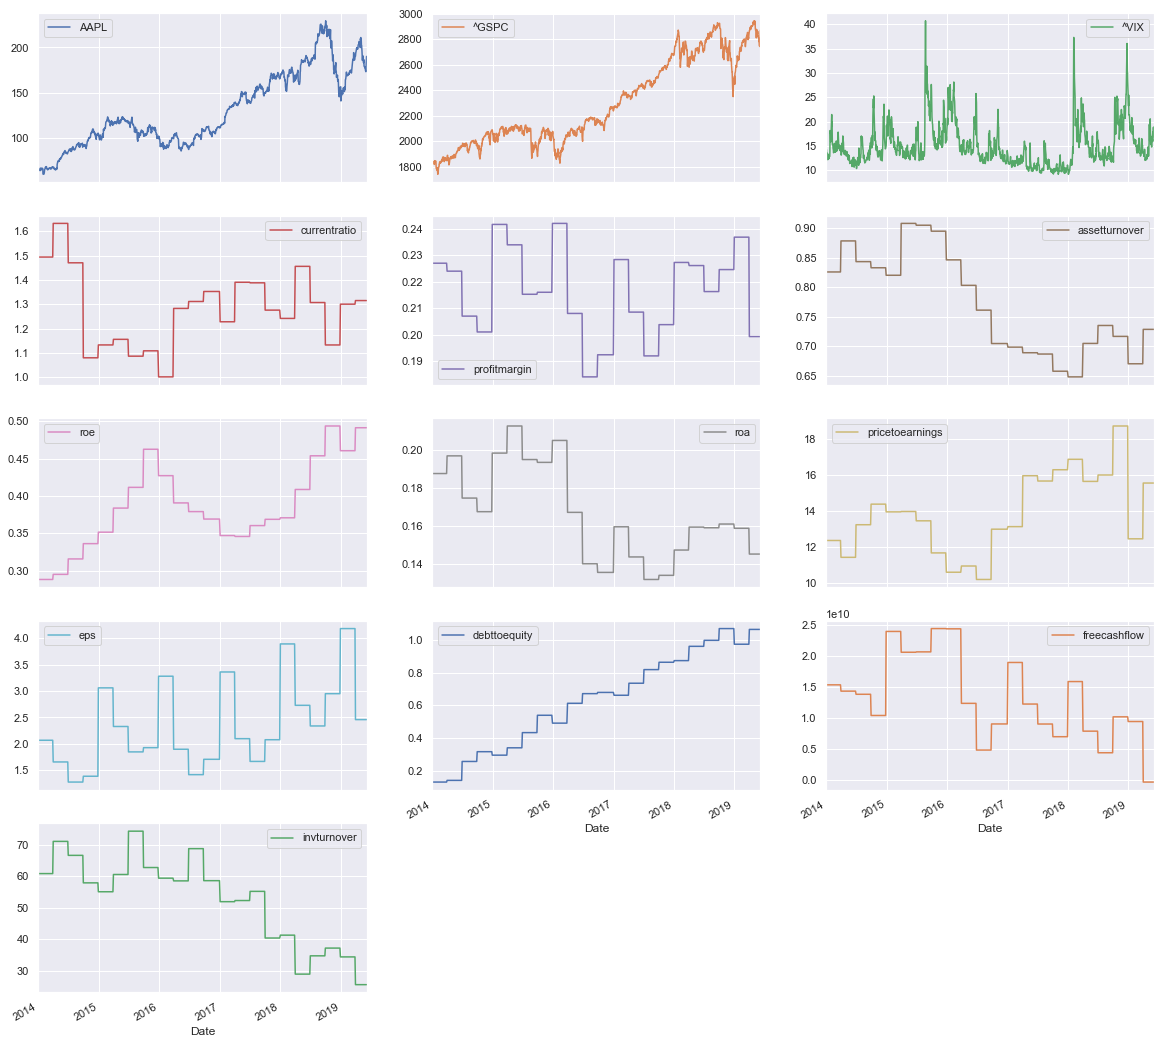

In [95]:
master_data.plot(subplots=True, layout=(5,3), figsize=(20,20))

In [96]:
master_data.corr()

,AAPL,^GSPC,^VIX,currentratio,profitmargin,assetturnover,roe,roa,pricetoearnings,eps,debttoequity,freecashflow,invturnover
AAPL,1.000000,0.966995,-0.074625,-0.063538,0.023488,-0.665872,0.628732,-0.499287,0.758419,0.452770,0.883582,-0.509471,-0.867833
^GSPC,0.966995,1.000000,-0.144523,0.049824,-0.033465,-0.775080,0.568625,-0.613459,0.702853,0.480162,0.919828,-0.597639,-0.894676
^VIX,-0.074625,-0.144523,1.000000,-0.423168,0.314386,0.208375,0.361255,0.309032,-0.034909,0.273807,0.011168,0.275606,-0.014869
currentratio,-0.063538,0.049824,-0.423168,1.000000,-0.244776,-0.226195,-0.483006,-0.295860,-0.033370,-0.289467,-0.060952,-0.457371,-0.024819
profitmargin,0.023488,-0.033465,0.314386,-0.244776,1.000000,0.209672,0.109537,0.662664,-0.009712,0.728662,-0.166396,0.616838,-0.164617
assetturnover,-0.665872,-0.775080,0.208375,-0.226195,0.209672,1.000000,-0.156401,0.869874,-0.536993,-0.408219,-0.789942,0.599253,0.708718
roe,0.628732,0.568625,0.361255,-0.483006,0.109537,-0.156401,1.000000,-0.070013,0.237871,0.393141,0.694606,-0.170442,-0.541012
roa,-0.499287,-0.613459,0.309032,-0.295860,0.662664,0.869874,-0.070013,1.000000,-0.412881,0.049509,-0.690805,0.772794,0.462475
pricetoearnings,0.758419,0.702853,-0.034909,-0.033370,-0.009712,-0.536993,0.237871,-0.412881,1.000000,0.220964,0.567283,-0.343372,-0.652070
eps,0.452770,0.480162,0.273807,-0.289467,0.728662,-0.408219,0.393141,0.049509,0.220964,1.000000,0.421638,0.207820,-0.576305


In [99]:
master_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AAPL,1368.0,1.297531e+02,4.067659e+01,6.027000e+01,9.963500e+01,1.168800e+02,1.651625e+02,2.293900e+02
^GSPC,1368.0,2.298004e+03,3.341789e+02,1.741890e+03,2.036965e+03,2.164225e+03,2.635743e+03,2.945830e+03
^VIX,1368.0,1.495939e+01,4.165945e+00,9.140000e+00,1.218000e+01,1.386500e+01,1.653250e+01,4.074000e+01
currentratio,1368.0,1.279875e+00,1.537545e-01,1.001700e+00,1.133000e+00,1.283100e+00,1.388300e+00,1.632600e+00
profitmargin,1368.0,2.161150e-01,1.615737e-02,1.840500e-01,2.037700e-01,2.161270e-01,2.272550e-01,2.420000e-01
assetturnover,1368.0,7.713477e-01,8.478509e-02,6.482000e-01,6.986000e-01,7.613000e-01,8.435000e-01,9.083000e-01
roe,1368.0,3.856569e-01,5.656353e-02,2.881450e-01,3.469460e-01,3.707050e-01,4.271230e-01,4.936360e-01
roa,1368.0,1.669860e-01,2.438675e-02,1.318640e-01,1.452030e-01,1.609700e-01,1.933470e-01,2.124510e-01
pricetoearnings,1368.0,1.386132e+01,2.209447e+00,1.017790e+01,1.235290e+01,1.345030e+01,1.567090e+01,1.874150e+01
eps,1368.0,2.337405e+00,7.914632e-01,1.280000e+00,1.710000e+00,2.080000e+00,2.950000e+00,4.180000e+00


In [37]:
#proseguire integrazione con mongodb o firestore


from pymongo import MongoClient
from bson.objectid import ObjectId

client = MongoClient('localhost', 27017)
db = client['finance_service']